# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in NumPy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [6]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log
from math import exp, tanh as math_tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    # Identity function
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

    # Hyperbolic tangent function
    def tanh(self):
        tanh_val = math_tanh(self.v)
        return Var(tanh_val, lambda: [(self, 1.0 - tanh_val ** 2)])

    # Sigmoid function
    def sigmoid(self):
        sigmoid_val = 1.0 / (1.0 + exp(-self.v))
        return Var(sigmoid_val, lambda: [(self, sigmoid_val * (1 - sigmoid_val))])

# Example usage:

a = Var(2.0)  # Create a variable with value 2.0

identity_a = a.identity()
tanh_a = a.tanh()
sigmoid_a = a.sigmoid()

print(f"Identity: {identity_a.v}")
print(f"Tanh: {tanh_a.v}")
print(f"Sigmoid: {sigmoid_a.v}")

Identity: 2.0
Tanh: 0.9640275800758169
Sigmoid: 0.8807970779778823


A few examples illustrate how we can use this:

In [8]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [9]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

# Solution

### Explanation of Differentiation

Given the operations performed in the code, we calculate gradients using automatic differentiation.

#### First Set of Variables and Operations:

1. **Variables:**
   - $a = 3.0$
   - $b = 5.0$
   - $f = a \cdot b$

#### Gradient Calculation for First Set

- Gradient of $f$ with respect to $a$ is $b$.

$$
\frac{\partial f}{\partial a} = b = 5.0
$$

- Gradient of $f$ with respect to $b$ is $a$.

$$
\frac{\partial f}{\partial b} = a = 3.0
$$

- Gradient of $f$ with respect to itself is 1.


#### Second Set of Variables and Operations:

1. **Variables:**
   - $a = 3.0$
   - $b = 5.0$
   - $c = a \cdot b$
   - $d = 9.0$
   - $e = a \cdot d$
   - $f = c + e$


2. **Expression for $f$:**

$$
f = a \cdot b + a \cdot d = a \cdot (b + d)
$$

#### Gradient Calculation for Second Set

- Gradient of $f$ with respect to $a$:

$$
\frac{\partial f}{\partial a} = b + d = 5.0 + 9.0 = 14.0
$$

- Gradient of $f$ with respect to $b$:

$$
\frac{\partial f}{\partial b} = a = 3.0
$$

- Gradient of $f$ with respect to $c$:

$$
\frac{\partial f}{\partial c} = 1
$$

- Gradient of $f$ with respect to $d$:

$$
\frac{\partial f}{\partial d} = a = 3.0
$$

- Gradient of $f$ with respect to $e$:

$$
\frac{\partial f}{\partial e} = 1
$$

- The value of $f$ is $42.0$ with gradient $1$ with respect to itself.


## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

In [18]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

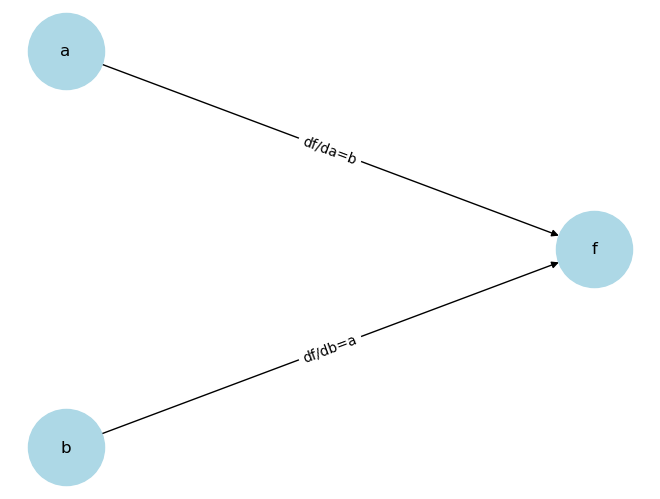

In [19]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=b')
G.add_edge('b', 'f', label='df/db=a')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

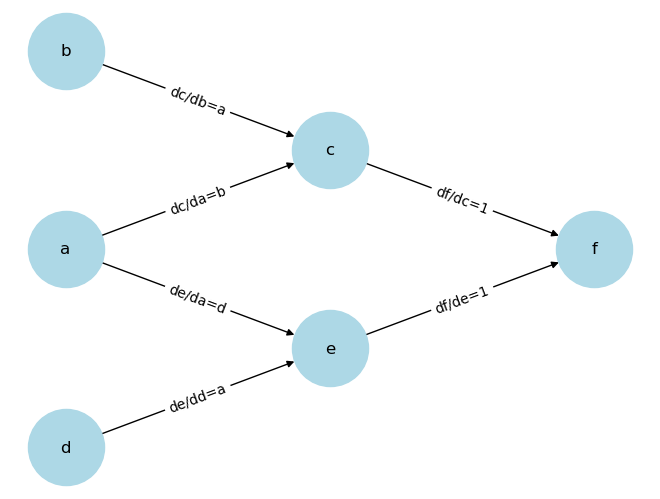

In [20]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=b')
G.add_edge('b', 'c', label='dc/db=a')
G.add_edge('a', 'e', label='de/da=d')
G.add_edge('d', 'e', label='de/dd=a')
G.add_edge('c', 'f', label='df/dc=1')
G.add_edge('e', 'f', label='df/de=1')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

# Solution 2

### Schematic of the Data Structure for the Expression $f = a \cdot b$

When defining the expression $f = a \cdot b$, a computational graph is created. Below is a schematic of the data structure that represents this expression, including the objects and their member variables:


#### Data Structure:

1. **Variable $a$:**
   - **Value:** $3.0$
   - **Gradient:** $0$ (initially, until backpropagation is performed)

2. **Variable $b$:**
   - **Value:** $5.0$
   - **Gradient:** $0$ (initially, until backpropagation is performed)

3. **Operation Node $f$:**
   - **Expression:** $f = a \cdot b$
   - **Value:** $15.0$ (computed as $3.0 \cdot 5.0$)
   - **Gradient:** $1$ (the gradient of $f$ with respect to itself)
   - **Gradients of Inputs:**
     - **Gradient with respect to $a$:** $\frac{\partial f}{\partial a} = b = 5.0$
     - **Gradient with respect to $b$:** $\frac{\partial f}{\partial b} = a = 3.0$


#### Detailed Breakdown:

- **Node $a$:**
  - **Attributes:**
    - **Value:** $3.0$
    - **Gradient:** $0$ (initially)
  - **Role:** Input variable in the expression $f$.


- **Node $b$:**
  - **Attributes:**
    - **Value:** $5.0$
    - **Gradient:** $0$ (initially)
  - **Role:** Input variable in the expression $f$.


- **Node $f$:**
  - **Attributes:**
    - **Value:** $15.0$
    - **Gradient:** $1$ (initially)
  - **Role:** Output variable resulting from the operation $a \cdot b$.
  - **Dependencies:**
    - **Depends on $a$ and $b$**.
    - **Gradient with respect to $a$ is $\frac{\partial f}{\partial a} = b = 5.0$**
    - **Gradient with respect to $b$ is $\frac{\partial f}{\partial b} = a = 3.0$**

The graph is used to compute the forward pass (to calculate the value of $f$) and the backward pass (to compute gradients with respect to $a$ and $b$).

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [31]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


# Solution

### Exercise c) What Happens if We Run `backward()` Again?

I assume that the `backward()` function is used to calculate the gradients of the variables with respect to the output. After running it the first time, the gradients are computed and stored in the variables. Now, I think running `backward()` again will show the updated gradients.

Here’s what I think happens:

1. **Initial Run of `backward()`:**
   - When we first run `backward()`, the gradients of the variables are calculated based on the current state of the computational graph. For example, if $f = a \cdot b + a \cdot d$, then the gradients $\frac{\partial f}{\partial a}$, $\frac{\partial f}{\partial b}$, and $\frac{\partial f}{\partial d}$ are calculated and stored.

2. **After Running `backward()` Again:**
   - Running `backward()` a second time will recalculate the gradients. However, since the graph hasn't changed and the values of $a$, $b$, and $d$ are still the same, the gradients should remain the same as they were after the first run.
   - In other words, the function doesn't "accumulate" gradients. It simply recalculates them from scratch each time. This means that the gradients you see are not added to any previously stored gradients but are instead freshly computed.

3. **Why This Happens:**
   - I think this is because the backward pass is designed to compute the gradient with respect to the current values of the variables. Since the variables and the computational graph haven't changed, the result of running `backward()` again will be the same as the first time.

In summary, running `backward()` again will give you the same gradients as before because it recalculates them from scratch based on the same inputs and computational graph.


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [35]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


# Solution

### Exercise d) Zero Gradient
I think these steps happen during this action:

1. **What is Zeroing the Gradient?**
   - Zeroing the gradient means setting the gradient of a variable to zero. This is useful when we want to start fresh or when we are done with a certain calculation and don't want the previous gradients to affect future computations.

2. **How We Zero the Gradient:**
   - In the example, it looks like we backpropagate a value of `-1.0`. This means we are telling the system that we want to compute the gradient with respect to some change that’s effectively the opposite of the usual forward pass. 
   - When we backpropagate `-1.0`, it changes the gradient values. Essentially, this `-1.0` acts like a "reset" for the gradient of the variable it's associated with.

3. **Why This Works:**
   - I think that backpropagating a value of `-1.0` adjusts the gradient to be zero. This happens because the backward function is designed to compute gradients based on the current state of the graph. By backpropagating `-1.0`, we are changing the influence on the gradients, which can effectively set them to zero.
   - If we run `backward()` multiple times without zeroing the gradients, they will accumulate. To avoid this, we need to zero them out by backpropagating the appropriate value or using specific methods provided in libraries like PyTorch or TensorFlow.

4. **Practical Example:**
   - For instance, if you have been running `backward()` and you see that the gradients are not resetting as expected, running the cell to zero the gradients (by backpropagating `-1.0`) will ensure that the gradients are cleared and you can start fresh.

In summary, zeroing the gradient by backpropagating `-1.0` helps reset the gradients so that they don't accumulate from previous calculations. This ensures that your gradients are properly initialized for new computations.


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [39]:
# Function to define the function f(a) and calculate its value and gradient
def f_function(a):
    a_var = Var(a)
    b_var = Var(5.0)
    f_var = a_var * b_var
    f_var.backward()
    
    # Extract numerical values for return
    return a_var.v, b_var.v, f_var.v

# Function to calculate the finite difference
def finite_difference(a, da=1e-10):
    """
    This function computes the finite difference approximation to the derivative of f(a) at a.

    Input:
    a:   The point at which to compute the derivative (float)
    da:  The finite difference step size (float)

    Output:
    finite_difference: numerical approximation to the derivative (float)
    """
    # Compute f(a) and f(a + da)
    a1, b1, f1 = f_function(a)
    a2, b2, f2 = f_function(a + da)
    
    # Numerical approximation to the derivative
    finite_diff = (f2 - f1) / da
    
    return finite_diff

# Example usage
a_value = 3.0
print(finite_difference(a_value))

5.000000413701855


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [42]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [43]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

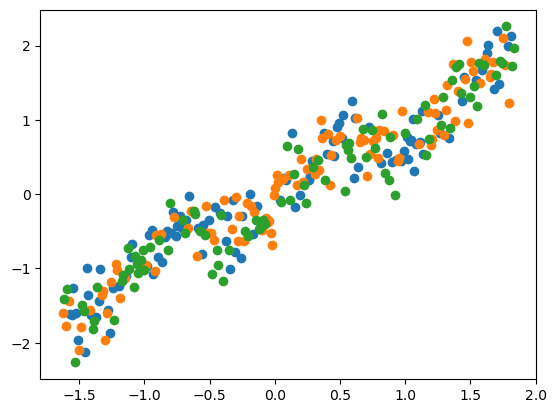

In [44]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [45]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)

# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [47]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [48]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [49]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Number of wghts: '+ repr(len(self.weights)) + '\nWeights: ' + repr(self.weights) +\
        '\nNumber of biases: '+ repr(len(self.bias)) + '\nBiases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        bias = self.bias
        out = []

        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.

            node = bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j] * single_input[i]  

            node = self.act_fn(node)
            out.append(node)

        # print(f"output passed: {out} \n")
        return out

## Exercise f) Add More Activation Functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [52]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))

[[Var(v=-0.0112, grad=0.0000)], [Var(v=-0.0224, grad=0.0000)], [Var(v=-0.0020, grad=0.0000)], [Var(v=-0.0302, grad=0.0000)], [Var(v=-0.0165, grad=0.0000)], [Var(v=-0.0153, grad=0.0000)], [Var(v=-0.0099, grad=0.0000)], [Var(v=-0.0073, grad=0.0000)], [Var(v=-0.0312, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=-0.0173, grad=0.0000)], [Var(v=-0.0192, grad=0.0000)], [Var(v=-0.0139, grad=0.0000)], [Var(v=-0.0220, grad=0.0000)], [Var(v=-0.0074, grad=0.0000)], [Var(v=-0.0144, grad=0.0000)], [Var(v=-0.0266, grad=0.0000)], [Var(v=-0.0126, grad=0.0000)], [Var(v=-0.0013, grad=0.0000)], [Var(v=-0.0044, grad=0.0000)], [Var(v=-0.0144, grad=0.0000)], [Var(v=-0.0063, grad=0.0000)], [Var(v=-0.0194, grad=0.0000)], [Var(v=-0.0196, grad=0.0000)], [Var(v=-0.0084, grad=0.0000)], [Var(v=-0.0227, grad=0.0000)], [Var(v=-0.0251, grad=0.0000)], [Var(v=-0.0276, grad=0.0000)], [Var(v=-0.0029, grad=0.0000)], [Var(v=-0.0174, grad=0.0000)], [Var(v=-0.0284, grad=0.0000)], [Var(v=-0.0042, grad=0.0000)], [Var(v=

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [54]:
def print_network_params(network):
    for i, layer in enumerate(network):
        print(f"\nLayer {i + 1}:")
        
        # Print weights
        print("Weights:")
        weights = layer.weights
        for row in weights:
            print(" ", [var.v for var in row])  # Assuming weights are Var objects

        # Print biases
        print("Biases:")
        biases = layer.bias
        print(" ", [var.v for var in biases])  # Assuming biases are Var objects

        print("-" * 40)  # Separator for readability

# Print all network parameters
print_network_params(NN)


Layer 1:
Weights:
  [-0.006080942570546484, 0.1398701920356908, -0.11828199754062191, 0.04122125246659076, 0.0705050039729254]
Biases:
  [0.0, 0.0, 0.0, 0.0, 0.0]
----------------------------------------

Layer 2:
Weights:
  [0.030927194833305617]
  [-0.11443083282764113]
  [-0.169553409143247]
  [0.023391426447744307]
  [-0.006269143048682622]
Biases:
  [0.0]
----------------------------------------


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

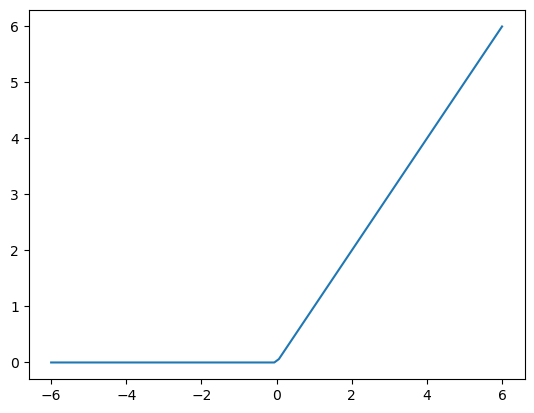

In [56]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

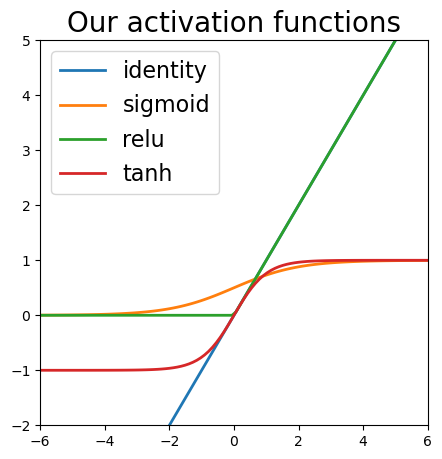

In [57]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [60]:
# Glorot Initialization (also known as Xavier Initialization)
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    std = np.sqrt(2 / (n_in + n_out))
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer=NormalInitializer(std))

# He Initialization
def DenseLayer_He_relu(n_in: int, n_out: int):
    std = np.sqrt(2 / n_in)
    return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer=NormalInitializer(std))

# Test Explanation

## Simple Testing of Weight Initializations

### Glorot (Xavier) Initialization

- **Purpose:** To keep activations stable.
- **Test Steps:**
  1. Initialize weights using Glorot.
  2. Run data through the network.
  3. Plot activations for each layer.
  4. Ensure activations don’t get too large or too small.

### He Initialization

- **Purpose:** To handle ReLU activations effectively.
- **Test Steps:**
  1. Initialize weights using He.
  2. Run data through the network.
  3. Plot activations for each layer.
  4. Ensure activations stay in a good range.

### Why It Matters

- **Glorot:** Prevents activations from becoming too extreme, helping with training.
- **He:** Keeps activations in a good range for networks using ReLU.


## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [64]:
# Insert code here
NN = [
    DenseLayer(1, 1, lambda x: x.identity(), initializer = ConstantInitializer()),
]

output = forward(x_train[:1], NN)

assert Var_to_nparray(x_train[:1]).item() == Var_to_nparray(output).item()

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [66]:
def squared_loss(t, y):
  
  # add check that sizes agree
  assert len(y) == len(t)
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [68]:
def cross_entropy_loss(t, h):
    # Compute exp(h) for each element in h
    exp_h = [Var(np.exp(hi)) for hi in h.v]
    
    # Compute sum of exp(h) for LogSumExp
    sum_exp_h = sum(hi.v for hi in exp_h)
    log_sum_exp_h = Var(np.log(sum_exp_h))
    
    # Compute p_i = exp(h_i) / sum(exp(h))
    p = [Var(hi.v / sum_exp_h) for hi in exp_h]
    
    # Compute -sum_i t_i * log(p_i)
    # Note: Assuming t is a Var with a one-hot vector, so it's a vector of the same length as h
    loss_sum = -sum(ti.v * np.log(pi.v) for ti, pi in zip(t.v, p))
    
    # Add LogSumExp(h) to the loss
    loss = Var(loss_sum + log_sum_exp_h.v)
    
    return loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [70]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [72]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Number of wghts: 1
Weights: [[Var(v=-0.0747, grad=6.6249), Var(v=-0.0062, grad=-6.4013), Var(v=-0.0711, grad=-0.0929), Var(v=0.0308, grad=6.3637), Var(v=0.1249, grad=-2.1853), Var(v=-0.0402, grad=-0.9211), Var(v=-0.1264, grad=1.7703), Var(v=-0.0226, grad=-2.9345), Var(v=0.0359, grad=7.8375), Var(v=0.1320, grad=6.9216), Var(v=0.0721, grad=-2.5199), Var(v=0.0168, grad=-7.6395), Var(v=0.1980, grad=-5.4655), Var(v=0.0744, grad=-2.8873), Var(v=0.0874, grad=-6.1107)]]
Number of biases: 15
Biases: [Var(v=0.0000, grad=-6.0210), Var(v=0.0000, grad=5.8178), Var(v=0.0000, grad=0.0844), Var(v=0.0000, grad=5.4676), Var(v=0.0000, grad=-1.8776), Var(v=0.0000, grad=0.8371), Var(v=0.0000, grad=-1.6090), Var(v=0.0000, grad=2.6670), Var(v=0.0000, grad=6.7338), Var(v=0.0000, grad=5.9469), Var(v=0.0000, grad=-2.1650), Var(v=0.0000, grad=-6.5637), Var(v=0.0000, grad=-4.6958), Var(v=0.0000, grad=-2.4807), Var(v=0.0000, grad=-5.2502)]
Layer 1 
 Number of wghts: 15
Weights: [[Var(v=-0.1785, grad=0.00

[None, None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [75]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [77]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Number of wghts: 1
Weights: [[Var(v=-0.0074, grad=-1.5850), Var(v=-0.0929, grad=-0.9701), Var(v=-0.0379, grad=1.1505), Var(v=-0.1340, grad=1.8758), Var(v=0.0995, grad=-4.9935), Var(v=-0.0088, grad=-1.9687), Var(v=-0.1013, grad=4.5804), Var(v=0.1904, grad=4.1401), Var(v=0.0155, grad=-7.6890), Var(v=0.0640, grad=0.0664), Var(v=0.0352, grad=6.2657), Var(v=0.0249, grad=5.9225), Var(v=-0.0495, grad=-2.1220), Var(v=0.0722, grad=1.0986), Var(v=-0.0050, grad=-2.1110)]]
Number of biases: 15
Biases: [Var(v=0.0000, grad=1.4405), Var(v=0.0000, grad=0.8816), Var(v=0.0000, grad=-1.0457), Var(v=0.0000, grad=-1.7048), Var(v=0.0000, grad=-4.2889), Var(v=0.0000, grad=1.7893), Var(v=0.0000, grad=-4.1629), Var(v=0.0000, grad=3.5559), Var(v=0.0000, grad=-6.6040), Var(v=0.0000, grad=0.0571), Var(v=0.0000, grad=5.3816), Var(v=0.0000, grad=5.0868), Var(v=0.0000, grad=1.9286), Var(v=0.0000, grad=0.9436), Var(v=0.0000, grad=1.9186)]
Layer 1 
 Number of wghts: 15
Weights: [[Var(v

[None, None, None]

In [78]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [79]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [80]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

   0 ( 0.00%) Train loss: 102.468 	 Validation loss: 99.276
  10 ( 5.00%) Train loss: 26.182 	 Validation loss: 19.471
  20 (10.00%) Train loss: 16.090 	 Validation loss: 11.882
  30 (15.00%) Train loss: 14.120 	 Validation loss: 10.474
  40 (20.00%) Train loss: 12.773 	 Validation loss: 9.696
  50 (25.00%) Train loss: 12.512 	 Validation loss: 9.411
  60 (30.00%) Train loss: 12.299 	 Validation loss: 9.226
  70 (35.00%) Train loss: 12.177 	 Validation loss: 9.107
  80 (40.00%) Train loss: 12.115 	 Validation loss: 9.051
  90 (45.00%) Train loss: 12.059 	 Validation loss: 8.998
 100 (50.00%) Train loss: 12.020 	 Validation loss: 8.965
 110 (55.00%) Train loss: 11.986 	 Validation loss: 8.948
 120 (60.00%) Train loss: 11.950 	 Validation loss: 8.940
 130 (65.00%) Train loss: 11.934 	 Validation loss: 8.926
 140 (70.00%) Train loss: 11.923 	 Validation loss: 8.928
 150 (75.00%) Train loss: 11.915 	 Validation loss: 8.931
 160 (80.00%) Train loss: 11.909 	 Validation loss: 8.935
 170 (85.

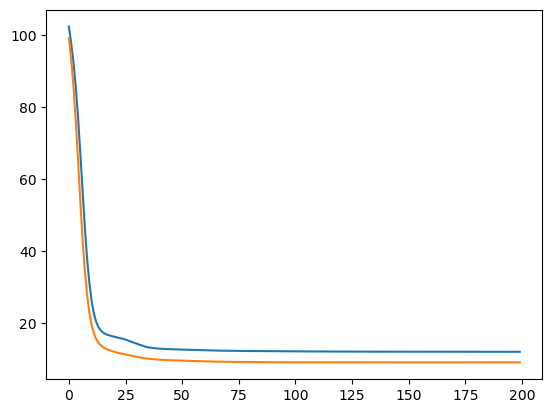

In [81]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [83]:
output_test = forward(x_test, NN)

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\szymo\AppData\Local\Temp\ipykernel_6468\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


Test loss:  9.774


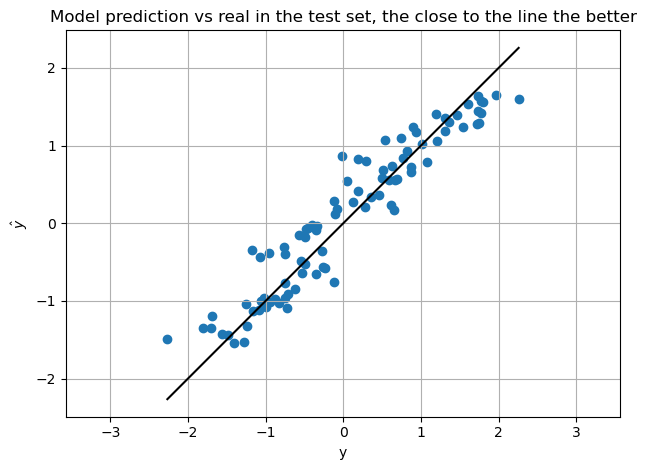

In [84]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

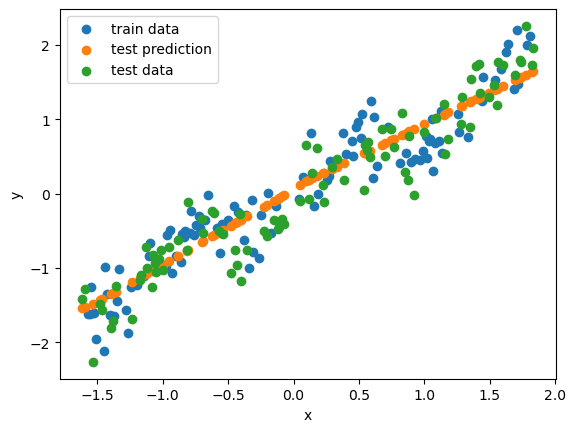

In [85]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

IIt is way easier for me to induce underfitting than overfitting, which is visible on the plots below. I would say the best idea to induce overfitting is actually updating the NN structure by inducing more (maybe even more complicated layers), implementing higher number of epochs or increasing the learning rate (or even combining all these approaches). If someone can provide a few tips on this, I'd be grateful :)}$Se



See also if you can get a good compromise which leads to a low validation 


Yes, it isn't visible at this point in my approach of overfitting, but when I increased the number of epochs it was posible to get test loss of around 8-9...
loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two se.

Keeping your validation and test sets separate is key for getting a clear picture of how well your model works. The validation set is used while you’re training and tweaking your model to get the best results. The test set, on the other hand, is saved for the end to see how your model performs on totally new data. If you mix these up, you might end up with a model that looks good on paper but doesn’t do as well in real-world situations. So, to get an honest evaluation, make sure the test set is only used after all your training and adjustments are done.

_Insert written answer here._


In [87]:
# Insert your code for getting overfitting, underfitting and just right fitting
'''It's below'''

"It's below"

# Underfitting training

In [89]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

In [90]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Number of wghts: 1
Weights: [[Var(v=0.1991, grad=2.3617), Var(v=0.1337, grad=-4.0228), Var(v=-0.0364, grad=0.7350), Var(v=-0.0195, grad=-2.0179), Var(v=0.2689, grad=-8.7531), Var(v=-0.1863, grad=-10.2462), Var(v=0.0086, grad=-0.0572), Var(v=0.0289, grad=12.9822), Var(v=0.1499, grad=-8.0822), Var(v=0.2046, grad=13.7974), Var(v=-0.1127, grad=2.2818), Var(v=0.0322, grad=-0.0213), Var(v=0.0884, grad=-5.6929), Var(v=0.0761, grad=6.8447), Var(v=0.0310, grad=9.0231)]]
Number of biases: 15
Biases: [Var(v=0.0000, grad=2.0288), Var(v=0.0000, grad=-3.4557), Var(v=0.0000, grad=-0.6683), Var(v=0.0000, grad=1.8348), Var(v=0.0000, grad=-7.5192), Var(v=0.0000, grad=9.3162), Var(v=0.0000, grad=-0.0492), Var(v=0.0000, grad=11.1520), Var(v=0.0000, grad=-6.9428), Var(v=0.0000, grad=11.8523), Var(v=0.0000, grad=-2.0747), Var(v=0.0000, grad=-0.0183), Var(v=0.0000, grad=-4.8903), Var(v=0.0000, grad=5.8797), Var(v=0.0000, grad=7.7511)]
Layer 1 
 Number of wghts: 15
Weights: [[

[None, None, None]

In [91]:
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [92]:
# Initialize training hyperparameters
EPOCHS = 5
LEARN_R = 2e-3

In [93]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

   0 ( 0.00%) Train loss: 96.713 	 Validation loss: 92.256


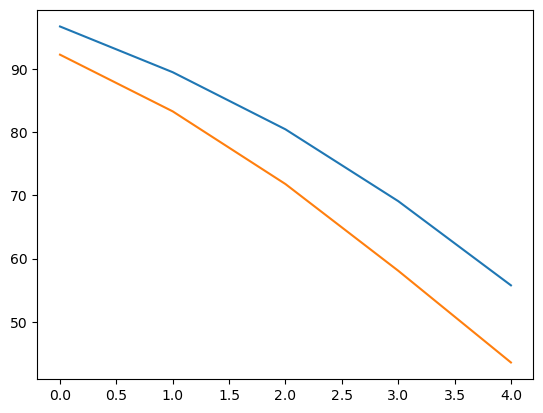

In [94]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

In [95]:
output_test = forward(x_test, NN)

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\szymo\AppData\Local\Temp\ipykernel_6468\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


Test loss:  40.840


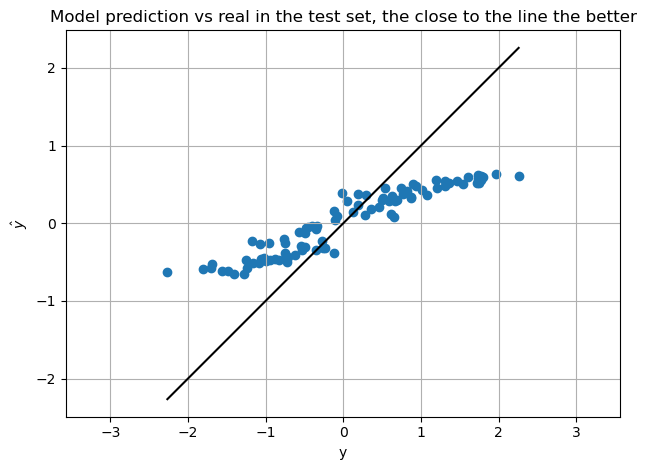

In [96]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

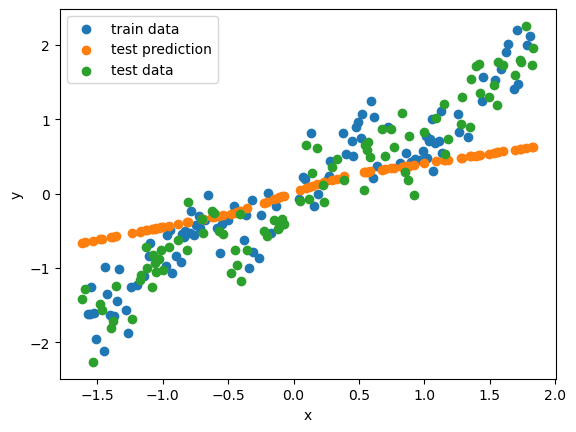

In [97]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

# Overrfitting training

In [99]:
# Increase the network complexity to induce overfitting
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

In [100]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Number of wghts: 1
Weights: [[Var(v=-0.0460, grad=6.3066), Var(v=0.0641, grad=-0.0592), Var(v=-0.0198, grad=3.2243), Var(v=0.0534, grad=-6.1432), Var(v=-0.0569, grad=3.3846), Var(v=0.0917, grad=0.8948), Var(v=0.0650, grad=-2.2714), Var(v=-0.0578, grad=-9.4916), Var(v=-0.1181, grad=-1.2163), Var(v=0.1345, grad=4.5216), Var(v=-0.0643, grad=8.1750), Var(v=-0.2161, grad=2.2697), Var(v=-0.0384, grad=-4.6431), Var(v=0.1431, grad=-3.9075), Var(v=-0.0086, grad=4.0707)]]
Number of biases: 15
Biases: [Var(v=0.0000, grad=-5.7316), Var(v=0.0000, grad=-0.0508), Var(v=0.0000, grad=-2.9303), Var(v=0.0000, grad=-5.2774), Var(v=0.0000, grad=-3.0760), Var(v=0.0000, grad=0.7687), Var(v=0.0000, grad=-1.9513), Var(v=0.0000, grad=8.6261), Var(v=0.0000, grad=1.1054), Var(v=0.0000, grad=3.8843), Var(v=0.0000, grad=-7.4296), Var(v=0.0000, grad=-2.0627), Var(v=0.0000, grad=4.2198), Var(v=0.0000, grad=-3.3567), Var(v=0.0000, grad=-3.6995)]
Layer 1 
 Number of wghts: 15
Weights: [

[None, None, None]

In [101]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 16, lambda x: x.relu()),
    DenseLayer(16, 8, lambda x: x.tanh()),
    DenseLayer(8, 4, lambda x: x.sigmoid()),
    DenseLayer(4, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [102]:
# Initialize training hyperparameters
EPOCHS = 125
LEARN_R = 2e-3

In [103]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))

   0 ( 0.00%) Train loss: 105.647 	 Validation loss: 108.259
  10 ( 8.00%) Train loss: 105.007 	 Validation loss: 107.758
  20 (16.00%) Train loss: 104.955 	 Validation loss: 107.702
  30 (24.00%) Train loss: 104.894 	 Validation loss: 107.637
  40 (32.00%) Train loss: 104.817 	 Validation loss: 107.554
  50 (40.00%) Train loss: 104.710 	 Validation loss: 107.438
  60 (48.00%) Train loss: 104.548 	 Validation loss: 107.263
  70 (56.00%) Train loss: 104.280 	 Validation loss: 106.971
  80 (64.00%) Train loss: 103.788 	 Validation loss: 106.427
  90 (72.00%) Train loss: 102.737 	 Validation loss: 105.246
 100 (80.00%) Train loss: 99.943 	 Validation loss: 102.029
 110 (88.00%) Train loss: 89.643 	 Validation loss: 89.796
 120 (96.00%) Train loss: 49.480 	 Validation loss: 45.361


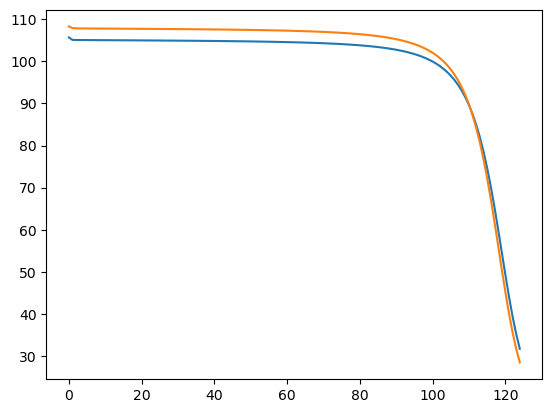

In [104]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

In [105]:
output_test = forward(x_test, NN)

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\szymo\AppData\Local\Temp\ipykernel_6468\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


Test loss:  27.508


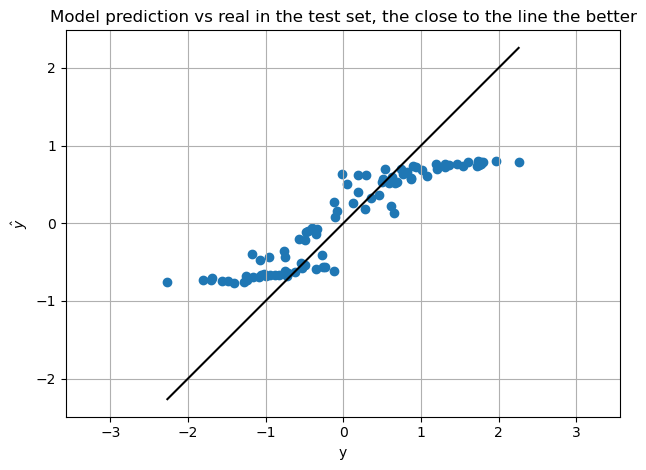

In [106]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

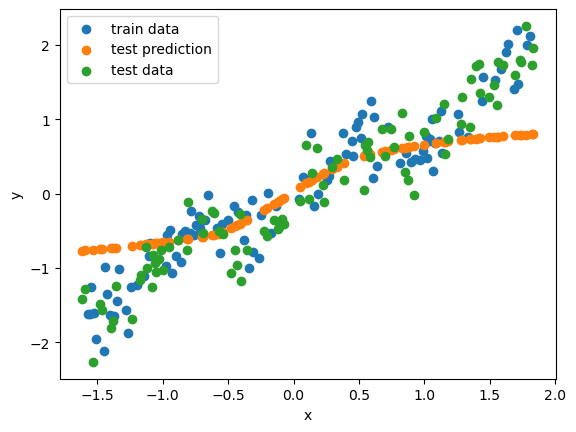

In [107]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [112]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [114]:
# just add some code